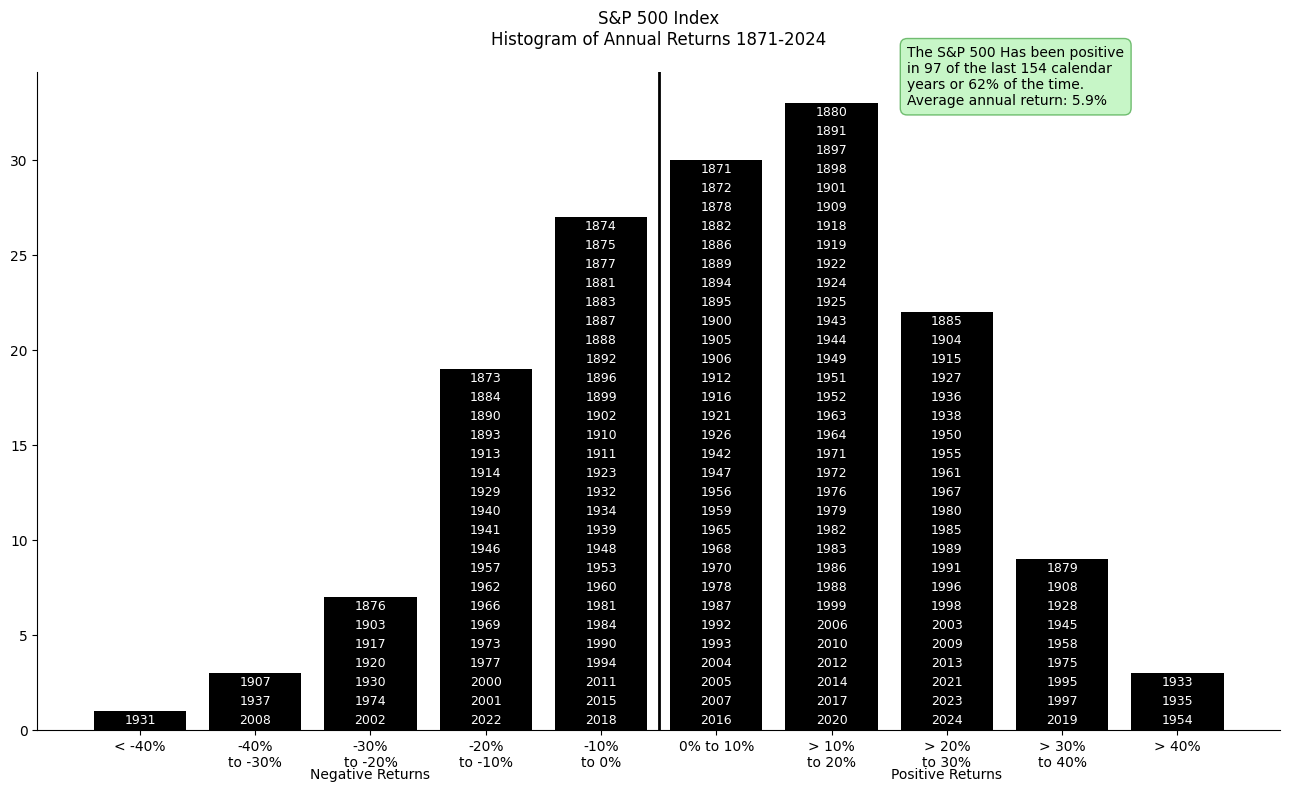

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_yearly_returns(csv_path, start_year=1926, end_year=2020):
    # Read the data
    df = pd.read_csv(csv_path)
    
    # Convert time column to datetime
    df['time'] = pd.to_datetime(df['time'])
    
    # Filter by year range
    df = df[(df['time'].dt.year >= start_year) & (df['time'].dt.year <= end_year)]
    
    # Calculate yearly returns
    df['yearly_return'] = ((df['close'] - df['open']) / df['open']) * 100
    
    # Create bins for the histogram
    bins = [-float('inf'), -40, -30, -20, -10, 0, 10, 20, 30, 40, float('inf')]
    labels = ['< -40%', '-40%\nto -30%', '-30%\nto -20%', '-20%\nto -10%', 
              '-10%\nto 0%', '0% to 10%', '> 10%\nto 20%', '> 20%\nto 30%', 
              '> 30%\nto 40%', '> 40%']
    
    # Categorize returns
    df['return_category'] = pd.cut(df['yearly_return'], bins=bins, labels=labels)
    
    # Count returns in each category
    returns_count = df['return_category'].value_counts().reindex(labels)
    
    # Create the plot
    plt.figure(figsize=(13, 8))
    
    # Split into negative and positive returns
    negative_returns = returns_count[:5]
    positive_returns = returns_count[5:]
    
    # Plot bars
    bars_negative = plt.bar(range(len(negative_returns)), 
                          negative_returns, 
                          color='black')
    
    bars_positive = plt.bar(range(len(negative_returns), len(returns_count)), 
                          positive_returns, 
                          color='black')
    
    # Add background colors
    # Customize the plot
    plt.title(f'S&P 500 Index\nHistogram of Annual Returns {start_year}-{end_year}', 
              pad=20, 
              fontsize=12)
    
    # Add years under each bar with dynamic spacing
    all_bars = bars_negative.patches + bars_positive.patches
    for i, bar in enumerate(all_bars):
        height = bar.get_height()
        years = df[df['return_category'] == returns_count.index[i]]['time'].dt.year
        years = sorted(years, reverse=True)
        
        if len(years) > 0:
            # Calculate spacing between years
            if height > 0:
                spacing = height / len(years)  # Evenly space across full height
                
                # Position years along the height of the bar
                for j, year in enumerate(years):
                    y_pos = (j + 0.2) * spacing  # Start from bottom with half-spacing offset
                    plt.text(i, y_pos, str(year),
                            ha='center',
                            va='bottom',
                            color='white',
                            fontsize=9,
                            zorder=3)
    
    # Set x-axis labels
    plt.xticks(range(len(labels)), 
               labels, 
               rotation=0, 
               ha='center')
    
    # Add vertical line at zero
    plt.axvline(x=4.5, color='black', linewidth=2, zorder=2)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Add text box with statistics
    positive_years = len(df[df['yearly_return'] > 0])
    total_years = len(df)
    avg_return = df['yearly_return'].mean()
    stats_text = f'The S&P 500 Has been positive\nin {positive_years} of the last {total_years} calendar\nyears or {int(positive_years/total_years*100)}% of the time.\nAverage annual return: {avg_return:.1f}%'
    
    #stats_text = ''
    plt.text(0.7, 0.95, 
            stats_text,
            transform=plt.gca().transAxes,
            bbox=dict(facecolor='lightgreen', 
                     alpha=0.5, 
                     edgecolor='green',
                     boxstyle='round,pad=0.5'))
    
    # Add 'Negative Returns' and 'Positive Returns' labels
    plt.text(2, -2, 'Negative Returns', ha='center', va='top')
    plt.text(7, -2, 'Positive Returns', ha='center', va='top')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_yearly_returns('path_to_your_csv/spx_yearly.csv', start_year=1926, end_year=2020)
plot_yearly_returns('CSV/spx_yearly.csv', start_year=1871, end_year=2024)

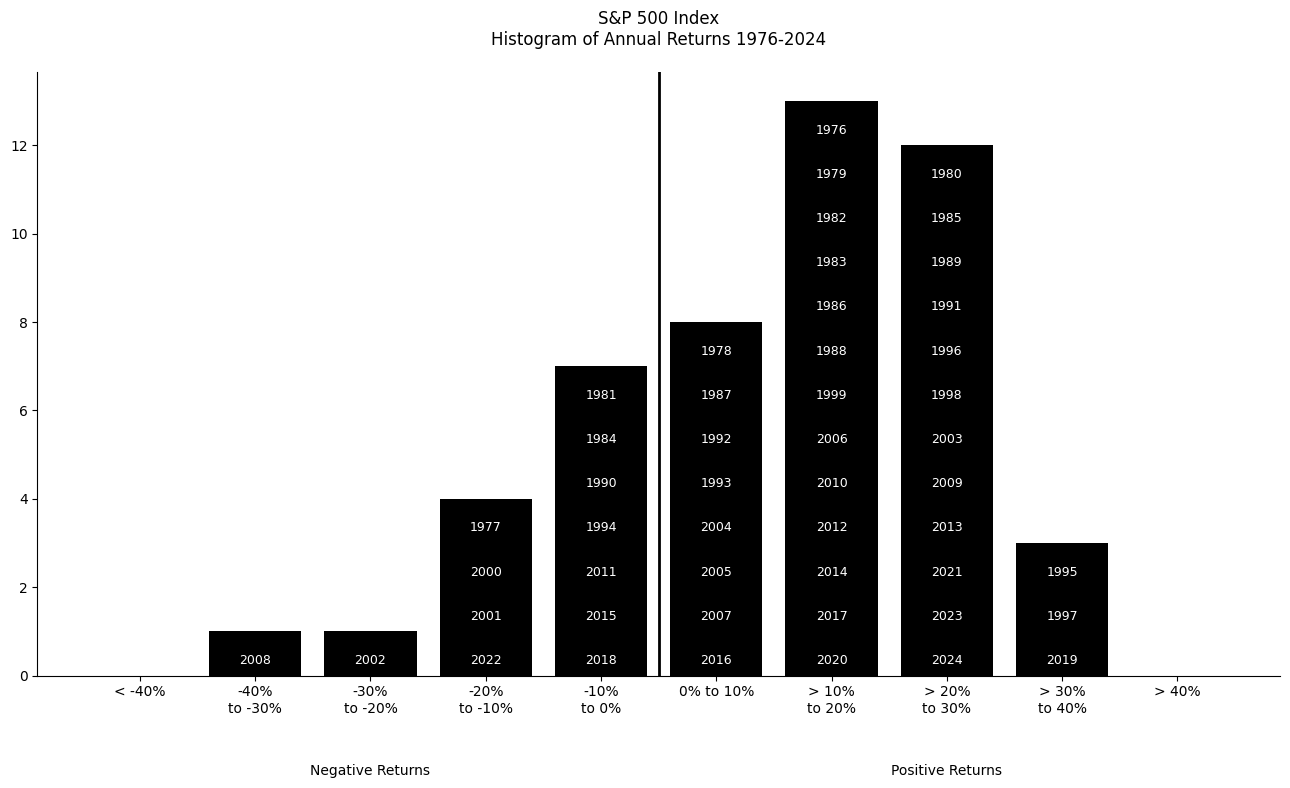

In [65]:
plot_yearly_returns('CSV/spx_yearly.csv', start_year=1976, end_year=2024)

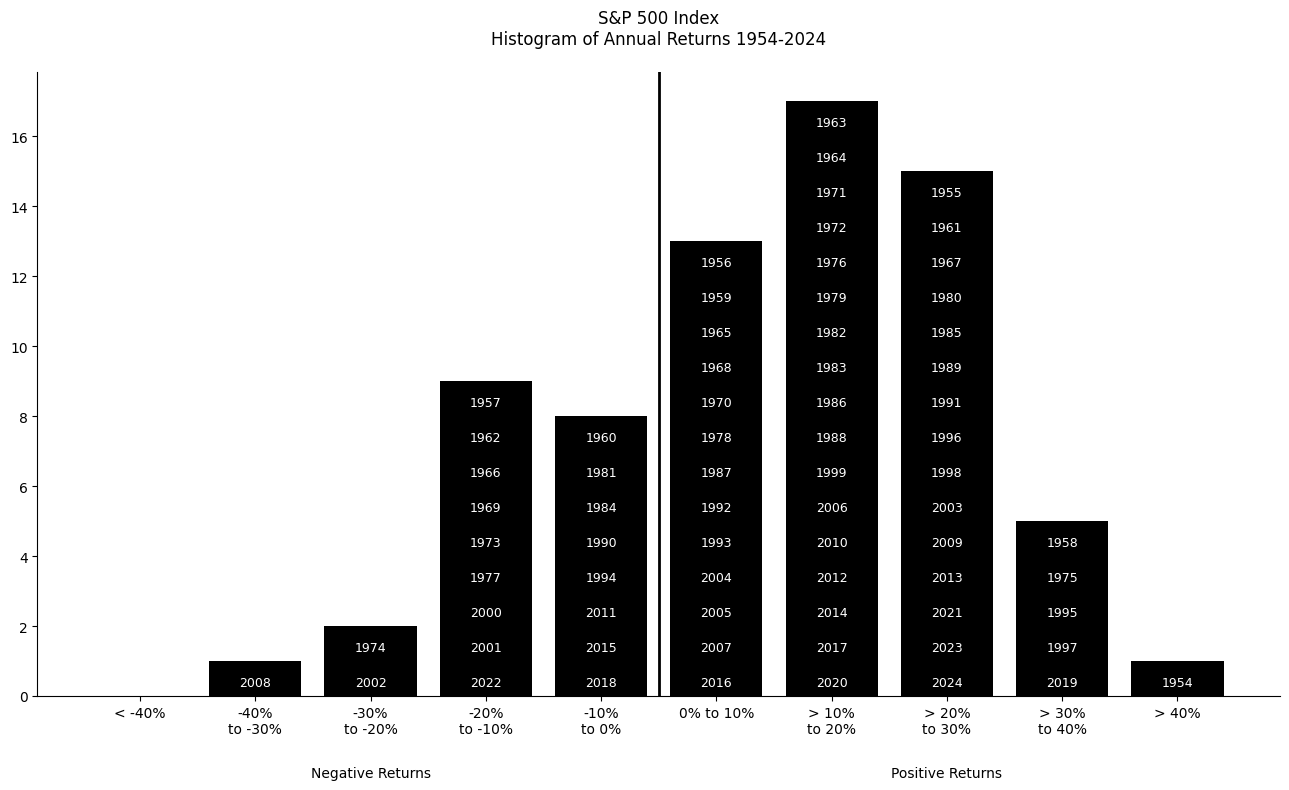

In [66]:
plot_yearly_returns('CSV/spx_yearly.csv', start_year=1954, end_year=2024)

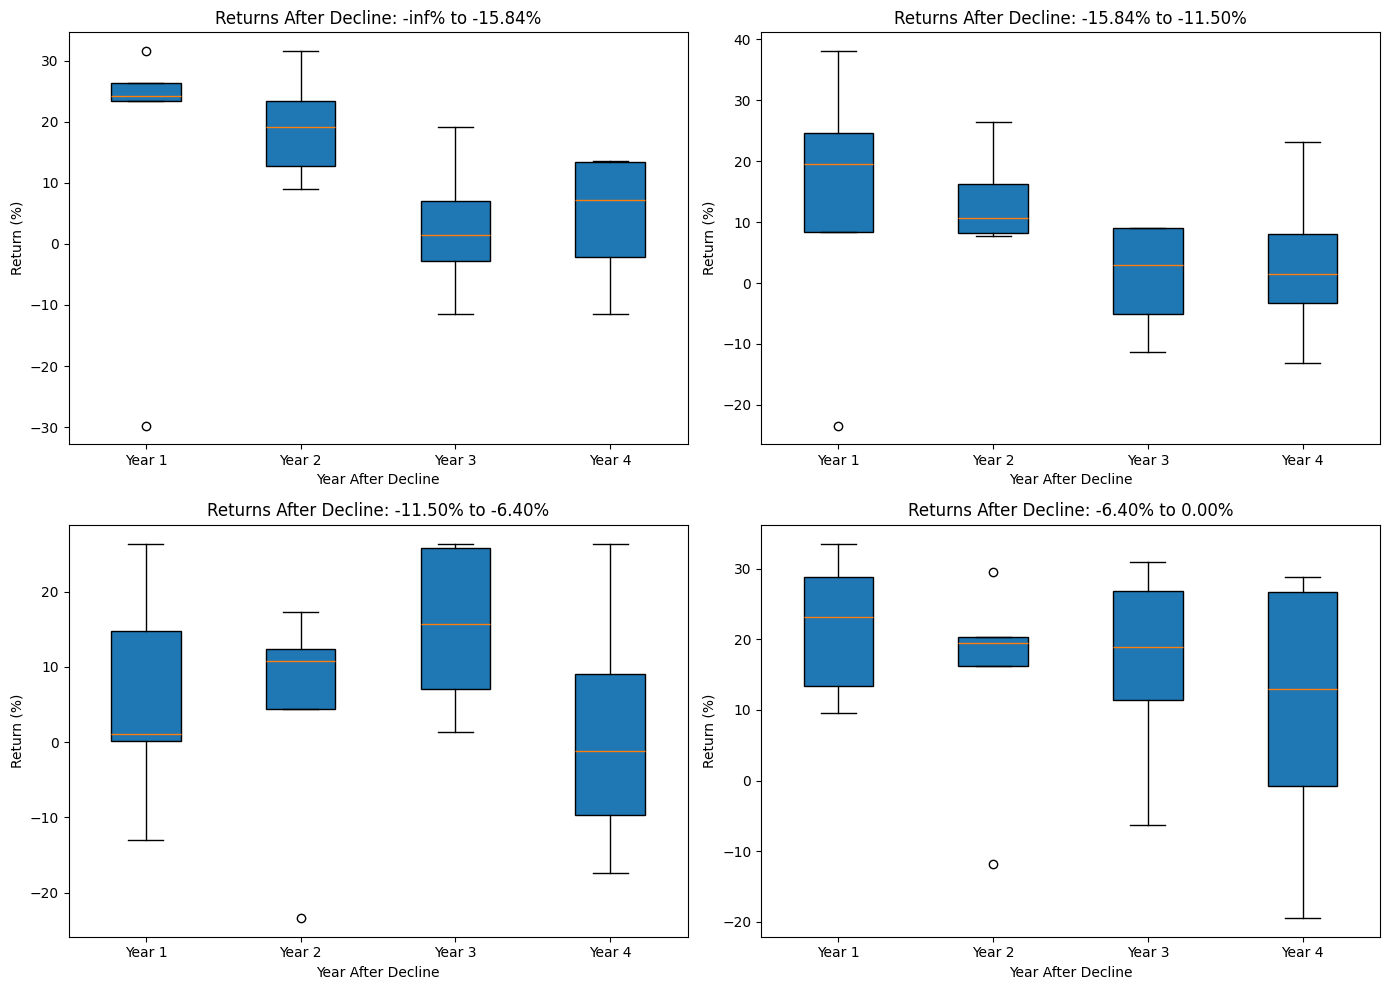

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_post_decline_returns_boxplot_quartiles(csv_path, years_ahead=4, start = 1954, end = 2024):
    # Read the data
    df = pd.read_csv(csv_path)
    df['time'] = pd.to_datetime(df['time'])
    df = df[(df['time'].dt.year >= start) & (df['time'].dt.year <= end)]
    df.sort_values('time', inplace=True)
    df['yearly_return'] = (df['close'].pct_change() * 100)
    
    # Filter for negative yearly returns only
    negative_returns = df[df['yearly_return'] < 0]['yearly_return']
    
    q1, q2, q3 = np.percentile(negative_returns, [25, 50, 75])
    
    # Define quartile ranges
    decline_ranges = [(-np.inf, q1), (q1, q2), (q2, q3), (q3, 0)]
    
    returns_after_declines = {f'{low:.2f}% to {high:.2f}%': {f'Year {i}': [] for i in range(1, years_ahead + 1)} 
                              for low, high in decline_ranges}
    
    # Extract returns for each quartile
    for low, high in decline_ranges:
        decline_indices = df[(df['yearly_return'] >= low) & (df['yearly_return'] < high)].index
        
        for idx in decline_indices:
            future_returns = df.loc[idx + 1: idx + years_ahead, 'yearly_return'].values
            for i in range(years_ahead):
                if i < len(future_returns):
                    returns_after_declines[f'{low:.2f}% to {high:.2f}%'][f'Year {i + 1}'].append(future_returns[i])
    
    plt.figure(figsize=(14, 10))

    for i, (decline_label, return_series) in enumerate(returns_after_declines.items()):
        plt.subplot(2, 2, i + 1)
        data = [return_series[f'Year {j}'] for j in range(1, years_ahead + 1)]
        
        plt.boxplot(data, tick_labels=[f'Year {j}' for j in range(1, years_ahead + 1)], patch_artist=True)
        
        plt.title(f'Returns After Decline: {decline_label}')
        plt.xlabel('Year After Decline')
        plt.ylabel('Return (%)')
        plt.grid(False)

    plt.tight_layout()
    
    plt.show()

plot_post_decline_returns_boxplot_quartiles('CSV/spx_yearly.csv')


In [105]:

df = pd.read_csv(csv_path)

df['time'] = pd.to_datetime(df['time'])

df = df[(df['time'].dt.year >= 1954) & (df['time'].dt.year <= 2024)]

df.sort_values('time', inplace=True)

df['yearly_return'] = (df['close'].pct_change() * 100)  # Shifted to capture "next year" returns

negative_returns = df[df['yearly_return'] < 0]

table_data = []
years_ahead = 4

for idx in negative_returns.index:
    date_of_decline = df.loc[idx, 'time'].strftime('%Y')
    decline_percent = round(df.loc[idx, 'yearly_return'], 2)
    
    # Get future returns for the next 4 years
    future_returns = round(df.loc[idx + 1: idx + years_ahead, 'yearly_return'], 2).values
    
    # Fill missing future years with NaN
    future_returns = list(future_returns) + [None] * (years_ahead - len(future_returns))
    
    # Append to table
    table_data.append([date_of_decline, decline_percent] + future_returns)

# Define column names
columns = ["Date of Decline", "Decline (%)"] + [f"Year {i} Return (%)" for i in range(1, years_ahead + 1)]

# Create DataFrame
decline_table = pd.DataFrame(table_data, columns=columns).sort_values(by='Decline (%)', ascending=True)

# Display the table
from IPython.display import display
display(decline_table)


,Date of Decline,Decline (%),Year 1 Return (%),Year 2 Return (%),Year 3 Return (%),Year 4 Return (%)
14,2008,-38.49,23.45,12.78,-0.00,13.41
6,1974,-29.72,31.55,19.15,-11.50,1.06
13,2002,-23.37,26.38,8.99,3.00,13.62
18,2022,-19.44,24.23,23.31,NaN,NaN
5,1973,-17.37,-29.72,31.55,19.15,-11.50
0,1957,-14.31,38.06,8.48,-2.97,23.13
3,1966,-13.09,20.09,7.66,-11.36,0.10
12,2001,-13.05,-23.37,26.38,8.99,3.00
2,1962,-11.81,18.89,12.97,9.06,-13.09
7,1977,-11.50,1.06,12.31,25.77,-9.73
